In [1]:
import heapq
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

# Задача классификации текстов

Задача классификации текстов заключается в том, чтобы определить по документу его класс.
В данном случае предлагается рассмотреть в качестве документов - письма, заранее отклассифицированных по 20 темам.

In [2]:
all_categories = fetch_20newsgroups().target_names
all_categories

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Возьмём всего 3 темы, но из одного раздела (документы из близких тем сложнее отличать друг от друга)

In [3]:
categories = [
    'sci.electronics',
    'sci.space',
    'sci.med'
]

train_data = fetch_20newsgroups(subset='train',
                                categories=categories,
                                remove=('headers', 'footers', 'quotes'))

test_data = fetch_20newsgroups(subset='test',
                               categories=categories,
                               remove=('headers', 'footers', 'quotes'))

## Векторизация текстов
**Вопрос: как описать текстовые документы пространством признаков?**


**Идея №1**: мешок слов (bag-of-words) - каждый документ или текст выглядит как неупорядоченный набор слов без сведений о связях между ними.
<img src='https://st2.depositphotos.com/2454953/9959/i/450/depositphotos_99593622-stock-photo-holidays-travel-bag-word-cloud.jpg'>

**Идея №2**: создаём вектор "слов", каждая компонента отвечает отдельному слову.

Для векторизации текстов воспользуемся CountVectorizer. Можно всячески варировать извлечение признаков (убирать редкие слова, убирать частые слова, убирать слова общей лексики, брать биграмы и т.д.)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [7]:
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [8]:
count_vectorizer = CountVectorizer(min_df=5, ngram_range=(1, 2)) 

In [9]:
sparse_feature_matrix = count_vectorizer.fit_transform(train_data.data)
sparse_feature_matrix

<1778x10885 sparse matrix of type '<class 'numpy.int64'>'
	with 216486 stored elements in Compressed Sparse Row format>

In [10]:
num_2_words = {
    v: k
    for k, v in count_vectorizer.vocabulary_.items()
}

Слова с наибольшим положительным весом, являются характерными словами темы

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV

In [6]:
f_scorer = make_scorer(f1_score, average='macro')

Обучим логистическую регрессию для предсказания темы документа

In [34]:
algo = LogisticRegression(C=0.00001)
algo.fit(sparse_feature_matrix, train_data.target)

/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [35]:
W = algo.coef_.shape[1]
for c in algo.classes_:
    topic_words = [
        num_2_words[w_num]
        for w_num in heapq.nlargest(10, range(W), key=lambda w: algo.coef_[c, w])
    ]
    print(',  '.join(topic_words))


wire,  ground,  wiring,  circuit,  use,  neutral,  power,  current,  voltage,  cable
of,  health,  medical,  in,  edu,  my,  patients,  and,  disease,  she
space,  nasa,  launch,  earth,  orbit,  satellite,  shuttle,  lunar,  moon,  on


Сравним качество на трейне и на отложенном тесте

In [36]:
algo.fit(sparse_feature_matrix, train_data.target)

LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [45]:
f_scorer(algo, sparse_feature_matrix, train_data.target)

0.42392759632757676

In [46]:
f_scorer(algo, count_vectorizer.transform(test_data.data), test_data.target)

0.38776774806066605

**Значения f-меры получились очень низкие**

**Вопрос: в чём причина?** 

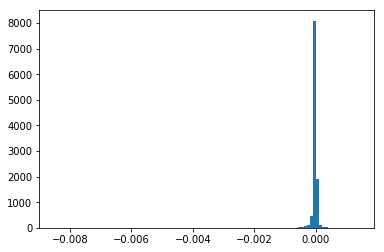

In [47]:
plt.hist(algo.coef_[0], bins=100)
plt.show()

** Какую выбрать метрику для регуляризации? **

In [48]:
algo = LogisticRegression(penalty='l1', C=0.1)
arr = cross_val_score(algo, sparse_feature_matrix, train_data.target, cv=5, scoring=f_scorer)
print(arr)
print(np.mean(arr))

/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[0.72677114 0.74655622 0.7306948  0.7503015  0.71598339]
0.7340614125302138


In [49]:
algo.fit(sparse_feature_matrix, train_data.target)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [50]:
f_scorer(algo, sparse_feature_matrix, train_data.target)

0.7952682014304938

In [51]:
f_scorer(algo, count_vectorizer.transform(test_data.data), test_data.target)

0.6826822308876733

Подберём оптимальное значение параметра регуляризации

In [7]:
def grid_plot(x, y, x_label, title, y_label='f_measure'):
    plt.figure(figsize=(12, 6))
    plt.grid(True),
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

In [32]:
print(*map(float, np.logspace(-2, 2, 10)))

0.01 0.027825594022071243 0.0774263682681127 0.21544346900318834 0.5994842503189409 1.6681005372000592 4.6415888336127775 12.915496650148826 35.93813663804626 100.0


In [57]:
lr_grid = {
    'C': np.logspace(-2, 2, 10),
}
gs = GridSearchCV(LogisticRegression(penalty='l1'), lr_grid, scoring=f_scorer, cv=5, n_jobs=5)
%time  gs.fit(sparse_feature_matrix, train_data.target)
print("best_params: {}, best_score: {}".format(gs.best_params_, gs.best_score_))

/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 20 s, sys: 359 ms, total: 20.3 s
Wall time: 3min 26s
best_params: {'C': 12.915496650148826}, best_score: 0.8097000247169784


/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


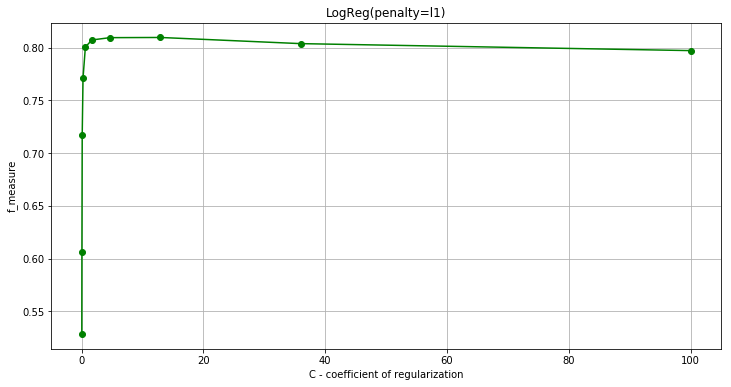

In [58]:
grid_plot(
    lr_grid['C'], gs.cv_results_['mean_test_score'], 'C - coefficient of regularization', 'LogReg(penalty=l1)'
)

In [59]:
lr_grid = {
    'C': np.linspace(1, 20, 40),
}
gs = GridSearchCV(LogisticRegression(penalty='l1'), lr_grid, scoring=f_scorer, cv=5, n_jobs=5)
%time  gs.fit(sparse_feature_matrix, train_data.target)
print("best_params: {}, best_score: {}".format(gs.best_params_, gs.best_score_))

/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 18.2 s, sys: 437 ms, total: 18.7 s
Wall time: 24min 48s
best_params: {'C': 11.717948717948717}, best_score: 0.8119672691072362


/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


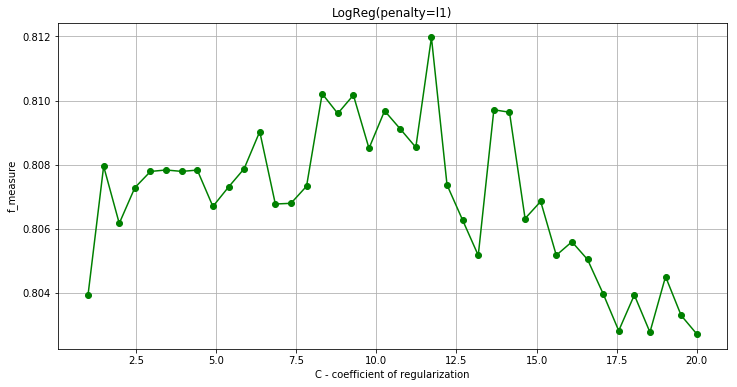

In [60]:
grid_plot(
    lr_grid['C'], gs.cv_results_['mean_test_score'], 'C - coefficient of regularization', 'LogReg(penalty=l1)'
)

In [61]:
lr_final = LogisticRegression(penalty='l1', C=10)
%time lr_final.fit(sparse_feature_matrix, train_data.target)

CPU times: user 20 s, sys: 55.5 ms, total: 20 s
Wall time: 20.1 s


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [62]:
accuracy_score(lr_final.predict(sparse_feature_matrix), train_data.target)

0.9808773903262092

In [63]:
f_scorer(lr_final, sparse_feature_matrix, train_data.target)

0.9810071221526965

In [64]:
accuracy_score(lr_final.predict(count_vectorizer.transform(test_data.data)), test_data.target)

0.7540152155536771

In [65]:
f_scorer(lr_final, count_vectorizer.transform(test_data.data), test_data.target)

0.7539068893782845

## Регуляризация вместе с векторизацией признаков
Чтобы не делать векторизацию и обучение раздельно, есть удобный класс Pipeline. Он позволяет объединить в цепочку последовательность действий

In [8]:
from sklearn.pipeline import Pipeline

In [81]:
pipeline = Pipeline([
    ("vectorizer", CountVectorizer(min_df=5, ngram_range=(1, 2))),
    ("algo", LogisticRegression())
])

In [82]:
pipeline.fit(train_data.data, train_data.target)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
       ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [83]:
f_scorer(pipeline, train_data.data, train_data.target)

0.9804363797868283

In [84]:
f_scorer(pipeline, test_data.data, test_data.target)

0.7930204194507636

Значения такие же как мы получали ранее, делая шаги раздельно.

In [9]:
from sklearn.pipeline import make_pipeline

При кроссвалидации нужно, чтобы CountVectorizer не обучался на тесте (иначе объекты становятся зависимыми). Pipeline позволяет это просто сделать.

In [79]:
pipeline = make_pipeline(CountVectorizer(min_df=5, ngram_range=(1, 2)), LogisticRegression())
arr = cross_val_score(pipeline, train_data.data, train_data.target, cv=5, scoring=f_scorer)
print(arr)
print(np.mean(arr))

/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[0.83746513 0.84655975 0.82308768 0.83985549 0.83173934]
0.8357414775322148


В Pipeline можно добавлять новые шаги препроцессинга данных

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer

In [86]:
pipeline = make_pipeline(CountVectorizer(min_df=5, ngram_range=(1, 2)), TfidfTransformer(), LogisticRegression())
arr = cross_val_score(pipeline, train_data.data, train_data.target, cv=5, scoring=f_scorer)
print(arr)
print(np.mean(arr))

/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maxim/code/git/ml-mipt/2019/env_ml_1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[0.8711115  0.8703129  0.8482986  0.85701424 0.84020672]
0.8573887943863149


In [87]:
pipeline.fit(train_data.data, train_data.target)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
  ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [90]:
accuracy_score(pipeline.predict(train_data.data), train_data.target)

0.96962879640045

In [91]:
f_scorer(pipeline, train_data.data, train_data.target)

0.9697797455997105

In [92]:
accuracy_score(pipeline.predict(test_data.data), test_data.target)

0.8241758241758241

In [93]:
f_scorer(pipeline, test_data.data, test_data.target)

0.8250417787917681

Качество стало немного лучше

# Классификация сообщений чатов

В качестве задания предлагается построить модель классификации текстов, соответствующих сообщениям из чатов по ML, Python и знакомствам.

**Данные** можно взять с <a src="https://www.kaggle.com/c/tfstextclassification">соревнования на Kaggle</a>, проведенное в рамках курса "Диалоговые системы" в Тинькофф.

In [11]:
data_path = 'data/{}'
df = pd.read_csv('data/train.csv')

### Посмотрим на данные

In [12]:
print(df.shape)

(112467, 3)


In [13]:
df.head()

,id,text,label
0,0,ж 44 позн с мужч от 40 лет 0678935919,1
1,1,уже и не вспомню где это увидел,2
2,2,", sep=';', decimal=',' может изза этого",2
3,3,НУЖНА ДЕВ ДЛЯ С\\О -19л.0637048428смс,1
4,4,.М54.ИЩУ Д.Ж. С-П.ДЛЯ ЛАСК...НЕКМ.0508665030....,1


In [14]:
label = 0
print('Label: ', label, '\n'+'='*100+'\n')
print(*df[df['label'] == label].sample(10).text, sep='\n'+'-'*100+'\n\n')

Label:  0 

А в чём загвоздка-то?
----------------------------------------------------------------------------------------------------

хм, приходит heart-beat': '10000,10000' но это все равно не в этом дело\nя не понял про слать heart beat
----------------------------------------------------------------------------------------------------

Стоит делать так, как удобно делать лично тебе или твоей команде. Если станет неудобно, переделаете рабочий процесс сразу же.
----------------------------------------------------------------------------------------------------

На си там только куски лексера и энкодера - https://github.com/python/cpython/blob/3.7/Modules/_json.c
----------------------------------------------------------------------------------------------------

    def __str__(self):\n        string_size = 20\n        name_string = str(self.name)\n        if len(name_string) > string_size:\n            name_string = name_string[0:string_size-3] + '...'\n        return '{:<10s}{:<20

In [15]:
label = 1
print('Label: ', label, '\n'+'='*100+'\n')
print(*df[df['label'] == label].sample(10).text, sep='\n'+'-'*100+'\n\n')

Label:  1 

ЛЮБИМЫЙ ЗНАЮ ЧТО МОЖНО НА ТРУБ.ПРИЕДУ НА НЕДЕЛЕ.ОЧЕНЬ СКУЧАЮ.КСЮНЯ
----------------------------------------------------------------------------------------------------

М.в годах. Хочу попробовать с женщиной. Днепр. 0666880067.
----------------------------------------------------------------------------------------------------

девушки  приезжайте в хорошую компанию.97 561 8200 97 561 8200
----------------------------------------------------------------------------------------------------

Девушки!кто хочет безумного вечера?Мужчина33.180.82.18см сначала смс0684361501
----------------------------------------------------------------------------------------------------

Зп/ШЕВЧИК.ХОЧУ МУЖЧИНУ СЕЙЧАС.СМС Предложения.0502526610
----------------------------------------------------------------------------------------------------

хочу познакомиться симпатичной девушкой 20-23 для с/о.0664778660.
---------------------------------------------------------------------------------------

In [16]:
label = 2
print('Label: ', label, '\n'+'='*100+'\n')
print(*df[df['label'] == label].sample(10).text, sep='\n'+'-'*100+'\n\n')

Label:  2 

Если интересно совсем с нуля\nто http://tryr.codeschool.com/\nтам прям совсем азы, и основы, но общее представление дает, хорошо еще, что онлайн, ставить не надо, можно потыкать, понять что не твое и отвалиться
----------------------------------------------------------------------------------------------------

Мне ж надо еще вспомнить, как их расставляли месяц с лишним назад :)
----------------------------------------------------------------------------------------------------

Ну не писать же в который раз, вот мы застакали 10  вариаций из 5 архитектур и получили золото на кэгле
----------------------------------------------------------------------------------------------------

Свод правил законов >> свод действий оператора ПК
----------------------------------------------------------------------------------------------------

А он разве ещё в бане?
----------------------------------------------------------------------------------------------------

да, кот здоровский, к

### Разделим данные на train/test

In [17]:
skf = StratifiedKFold(3, random_state=37)
train_index, test_index = next(skf.split(df.text, df.label))
train_df, test_df = df.iloc[train_index], df.iloc[test_index]
print(train_df.shape, test_df.shape)

(74977, 3) (37490, 3)


In [18]:
train_df.head()

,id,text,label
37334,37334,.Молодой красивый спортивный парень ищет серьё...,1
37335,37335,вы озабоченые уточняю для даши было написано:)...,1
37336,37336,КАБАСЯ Я ТЕБЯ ЛЮБЛЮ И ОЧЕНЬ СКУЧАЮ...ТВОЯ ВИТА...,1
37337,37337,парень ищет парня для и\\о 093 783 37 87,1
37339,37339,РОЗСЛАБЛЮ В НОЧНОЕ ВРЕМЯ ПО ТЕЛЕФОНУ.ЦЕНА 10Г....,1


In [19]:
test_df.head()

,id,text,label
0,0,ж 44 позн с мужч от 40 лет 0678935919,1
1,1,уже и не вспомню где это увидел,2
2,2,", sep=';', decimal=',' может изза этого",2
3,3,НУЖНА ДЕВ ДЛЯ С\\О -19л.0637048428смс,1
4,4,.М54.ИЩУ Д.Ж. С-П.ДЛЯ ЛАСК...НЕКМ.0508665030....,1


## Baseline

In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from xgboost.sklearn import XGBClassifier

Преобразуем данные

In [84]:
X_train = train_df.text
y_train = train_df.label
print(X_train.shape)

X_test = test_df.text
y_test = test_df.label
print(X_test.shape)

(74977,)
(37490,)


Подготовим pipeline

In [85]:
pipeline = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("clf", DecisionTreeClassifier()),
])

Обучим классификатор

In [86]:
%%time
clf = pipeline
clf.fit(X_train, y_train)

CPU times: user 1min, sys: 398 ms, total: 1min 1s
Wall time: 1min 2s


Оценим качество

In [87]:
print("Train_acc: {:.4f}, train_f-measure: {:.4f}".format(
    accuracy_score(clf.predict(X_train), y_train),
    f_scorer(clf, X_train, y_train)
))

Train_acc: 0.9998, train_f-measure: 0.9998


In [88]:
print("Test_acc: {:.4f}, test_f-measure: {:.4f}".format(
    accuracy_score(clf.predict(X_test), y_test),
    f_scorer(clf, X_test, y_test)
))

Test_acc: 0.7898, test_f-measure: 0.7259


# Ваши идеи